In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Download News Group 20 Dataset

In [2]:
#download data
data_path = keras.utils.get_file(
    "news20.tar.gz",
    "http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz",
    untar=True,
)

17334272/17329808 [==============================] - 19s 1us/step


In [3]:
import os
import pathlib

data_dir = pathlib.Path(data_path).parent / "20_newsgroup"
dirnames = os.listdir(data_dir)
print("Number of directories:", len(dirnames))
print("Directory names:", dirnames)

fnames = os.listdir(data_dir / "comp.graphics")
print("Number of files in comp.graphics:", len(fnames))
print("Some example filenames:", fnames[:5])


Number of directories: 20
Directory names: ['comp.sys.ibm.pc.hardware', 'talk.politics.mideast', 'misc.forsale', 'comp.windows.x', 'rec.motorcycles', 'sci.crypt', 'rec.sport.hockey', 'talk.politics.guns', 'comp.sys.mac.hardware', 'sci.med', 'sci.electronics', 'sci.space', 'comp.os.ms-windows.misc', 'comp.graphics', 'soc.religion.christian', 'rec.sport.baseball', 'talk.religion.misc', 'talk.politics.misc', 'alt.atheism', 'rec.autos']
Number of files in comp.graphics: 1000
Some example filenames: ['38764', '38362', '37919', '38587', '38436']


# Data preprocessing

In [5]:
#data preprocessing
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        lines = content.split("\n")
        lines = lines[10:]
        content = "\n".join(lines)
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))


Processing alt.atheism, 1000 files found
Processing comp.graphics, 1000 files found
Processing comp.os.ms-windows.misc, 1000 files found
Processing comp.sys.ibm.pc.hardware, 1000 files found
Processing comp.sys.mac.hardware, 1000 files found
Processing comp.windows.x, 1000 files found
Processing misc.forsale, 1000 files found
Processing rec.autos, 1000 files found
Processing rec.motorcycles, 1000 files found
Processing rec.sport.baseball, 1000 files found
Processing rec.sport.hockey, 1000 files found
Processing sci.crypt, 1000 files found
Processing sci.electronics, 1000 files found
Processing sci.med, 1000 files found
Processing sci.space, 1000 files found
Processing soc.religion.christian, 997 files found
Processing talk.politics.guns, 1000 files found
Processing talk.politics.mideast, 1000 files found
Processing talk.politics.misc, 1000 files found
Processing talk.religion.misc, 1000 files found
Classes: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.ha

In [6]:
# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]


In [7]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

In [8]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [13]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-05-18 16:23:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-05-18 16:23:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-05-18 16:23:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.2’

glove

# GloVe Embedding

In [15]:
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "/content/glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [17]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 17968 words (2032 misses)


# Embedding layer and models

In [18]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [872]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()


Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_84 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
conv1d_249 (Conv1D)          (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_166 (MaxPoolin (None, None, 128)         0         
_________________________________________________________________
conv1d_250 (Conv1D)          (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_167 (MaxPoolin (None, None, 128)         0         
_________________________________________________________________
conv1d_251 (Conv1D)          (None, None, 128)         820

# Baseline Training

In [427]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [873]:
opt = keras.optimizers.Adam(learning_rate=0.001)

In [874]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"]
)
model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))


Epoch 1/20
125/125 [==============================] - 2s 10ms/step - loss: 2.9187 - acc: 0.0770 - val_loss: 2.2135 - val_acc: 0.2203
Epoch 2/20
125/125 [==============================] - 1s 9ms/step - loss: 2.1700 - acc: 0.2398 - val_loss: 1.5946 - val_acc: 0.4429
Epoch 3/20
125/125 [==============================] - 1s 8ms/step - loss: 1.6099 - acc: 0.4357 - val_loss: 1.2974 - val_acc: 0.5511
Epoch 4/20
125/125 [==============================] - 1s 8ms/step - loss: 1.2796 - acc: 0.5509 - val_loss: 1.1823 - val_acc: 0.5914
Epoch 5/20
125/125 [==============================] - 1s 8ms/step - loss: 1.0758 - acc: 0.6223 - val_loss: 1.0669 - val_acc: 0.6327
Epoch 6/20
125/125 [==============================] - 1s 8ms/step - loss: 0.9001 - acc: 0.6852 - val_loss: 1.0785 - val_acc: 0.6387
Epoch 7/20
125/125 [==============================] - 1s 8ms/step - loss: 0.7686 - acc: 0.7312 - val_loss: 1.0312 - val_acc: 0.6524
Epoch 8/20
125/125 [==============================] - 1s 8ms/step - loss: 0

In [424]:
score = model.evaluate(x=x_val,y=y_val)

125/125 [==============================] - 0s 2ms/step - loss: 1.3195 - acc: 0.7097


# Reptile Algorithm

In [25]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [71]:
data_each_class_train = []
for i in range(20):
    temp = []
    for k in range(len(y_train)):
      if y_train[k] == i:
        temp.append(x_train[k])
    temp = np.array(temp)
    data_each_class_train.append(temp)

In [72]:
data_each_class_val = []
for i in range(20):
    temp = []
    for k in range(len(y_val)):
      if y_val[k] == i:
        temp.append(x_val[k])
    temp = np.array(temp)
    data_each_class_val.append(temp)

In [231]:
import random

In [246]:
#create dataset for Reptile, This dataset function is written specificially for News Group 20 dataset.
def create_minidataset(inner_batch_size, inner_iters, train_shots, classes, train=True):
    chosen_classes = random.sample(range(0, 20), classes)
    sampled_data = []
    sampled_label = []
    if train:
      for i in chosen_classes:
          index = random.sample(range(0,len(data_each_class_train[i])),train_shots)
          for k in index:
              sampled_data.append(data_each_class_train[i][k])
              sampled_label.append(i)
      sampled_data = np.array(sampled_data)
      sampled_label = np.array(sampled_label)

      dataset = tf.data.Dataset.from_tensor_slices(
            (tf.constant(sampled_data), tf.constant(sampled_label)))
      dataset = dataset.shuffle(buffer_size=train_shots*classes).batch(inner_batch_size).repeat(inner_iters)
      return dataset
    
    if not train:
      #sample from train set
      sampled_data_val = []
      sampled_label_val = []
      for i in chosen_classes:
          index = random.sample(range(0,len(data_each_class_train[i])),train_shots+1)
          for k in index:
              if k != index[-1]:
                sampled_data.append(data_each_class_train[i][k])
                sampled_label.append(i)
              else:
                sampled_data_val.append(data_each_class_train[i][k])
                sampled_label_val.append(i)

      sampled_data = np.array(sampled_data[:-1])
      sampled_label = np.array(sampled_label[:-1])

      train_dataset = tf.data.Dataset.from_tensor_slices(
            (tf.constant(sampled_data), tf.constant(sampled_label)))
      train_dataset = train_dataset.shuffle(buffer_size=train_shots*classes).batch(inner_batch_size).repeat(inner_iters)
      
      #sampled from test set
      sampled_data1 = []
      sampled_label1 = []
      sampled_data_val1 = []
      sampled_label_val1 = []
      for i in chosen_classes:
          index = random.sample(range(0,len(data_each_class_val[i])),train_shots+1)
          for k in index:
              if k != index[-1]:
                sampled_data1.append(data_each_class_val[i][k])
                sampled_label1.append(i)
              else:
                sampled_data_val1.append(data_each_class_val[i][k])
                sampled_label_val1.append(i)

      sampled_data1 = np.array(sampled_data1[:-1])
      sampled_label1 = np.array(sampled_label1[:-1])

      train_dataset1 = tf.data.Dataset.from_tensor_slices(
            (tf.constant(sampled_data1), tf.constant(sampled_label1)))
      train_dataset1 = train_dataset1.shuffle(buffer_size=train_shots*classes).batch(inner_batch_size).repeat(inner_iters)

      return train_dataset, tf.constant(sampled_data_val), tf.constant(sampled_label_val), train_dataset1, tf.constant(sampled_data_val1), tf.constant(sampled_label_val1)

In [861]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(class_names), activation="softmax")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_82 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 100)         2000200   
_________________________________________________________________
conv1d_243 (Conv1D)          (None, None, 128)         64128     
_________________________________________________________________
max_pooling1d_162 (MaxPoolin (None, None, 128)         0         
_________________________________________________________________
conv1d_244 (Conv1D)          (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_163 (MaxPoolin (None, None, 128)         0         
_________________________________________________________________
conv1d_245 (Conv1D)          (None, None, 128)         820

In [862]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["acc"]
)
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [863]:
#Reptile Configuration
learning_rate = 0.001
meta_step_size = 0.25

inner_batch_size = 32
eval_batch_size = 32

meta_iters = 1500
eval_iters = 5
inner_iters = 1

eval_interval = 1
train_shots = 1
#shots = 10
classes = 5

In [864]:
training = []
testing = []
for meta_iter in range(meta_iters):
    frac_done = meta_iter / meta_iters
    cur_meta_step_size = (1 - frac_done) * meta_step_size
    # Temporarily save the weights from the model.
    old_vars = model.get_weights()
    # Get a sample from the full dataset.
    mini_dataset = create_minidataset(inner_batch_size, inner_iters, train_shots, classes, train=True)

    for texts, labels in mini_dataset: #this loop perform SGD k times
        with tf.GradientTape() as tape:
            preds = model(texts)
            loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    new_vars = model.get_weights() #weight here = initial_weight + g1 +g2 +...+ gk
    # Perform SGD for the meta step.
    for var in range(len(new_vars)):
        new_vars[var] = old_vars[var] + (
            (new_vars[var] - old_vars[var]) * cur_meta_step_size
        )
    # After the meta-learning step, reload the newly-trained weights into the model.
    model.set_weights(new_vars)
    # Evaluation loop
    if meta_iter % eval_interval == 0:
        accuracies = []
      
        # Sample a mini dataset from the full dataset.
        train_miniset, vt, vl, train_miniset1, vt1, vl1 = create_minidataset(inner_batch_size, inner_iters, train_shots, classes, train=False)
        for miniset in ((train_miniset, vt,vl),(train_miniset1, vt1, vl1)):
            old_vars = model.get_weights()
            # Train on the samples and get the resulting accuracies.
            for texts, labels in miniset[0]:
                with tf.GradientTape() as tape:
                    preds = model(texts)
                    loss = keras.losses.sparse_categorical_crossentropy(labels, preds)
                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
            test_preds = model.predict(miniset[1])
            test_preds = tf.argmax(test_preds,axis=1).numpy()
            num_correct = (test_preds == miniset[2].numpy()).sum()
            # Reset the weights after getting the evaluation accuracies.
            model.set_weights(old_vars)
            accuracies.append(num_correct / classes)
        training.append(accuracies[0])
        testing.append(accuracies[1])
        if meta_iter % 100 == 0:
            print(
                "batch %d: train=%f test=%f" % (meta_iter, accuracies[0], accuracies[1])
            )

batch 0: train=0.000000 test=0.000000
batch 100: train=0.000000 test=0.200000
batch 200: train=0.200000 test=0.200000
batch 300: train=0.200000 test=0.400000
batch 400: train=0.200000 test=0.200000
batch 500: train=0.000000 test=0.400000
batch 600: train=0.000000 test=0.000000
batch 700: train=0.000000 test=0.000000
batch 800: train=0.800000 test=0.800000
batch 900: train=0.000000 test=0.600000
batch 1000: train=0.000000 test=0.200000
batch 1100: train=0.000000 test=0.000000
batch 1200: train=0.000000 test=0.600000
batch 1300: train=0.400000 test=0.200000
batch 1400: train=0.400000 test=0.200000


In [237]:
import matplotlib.pyplot as plt


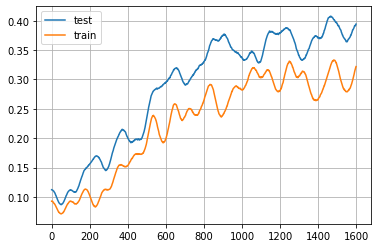

In [846]:
# First, some preprocessing to smooth the training and testing arrays for display.
window_length = 100
train_s = np.r_[
    training[window_length - 1 : 0 : -1], training, training[-1:-window_length:-1]
]
test_s = np.r_[
    testing[window_length - 1 : 0 : -1], testing, testing[-1:-window_length:-1]
]
w = np.hamming(window_length)
train_y = np.convolve(w / w.sum(), train_s, mode="valid")
test_y = np.convolve(w / w.sum(), test_s, mode="valid")

# Display the training accuracies.
x = np.arange(0, len(test_y), 1)
plt.plot(x, test_y, x, train_y)
plt.legend(["test", "train"])
plt.grid()


#plt.savefig('/content/drive/MyDrive/Advanced project/c1_n1_k1m.png',dpi=1000)